[1.  0.5 0.  0.  0. ]
[1.  0.5 0.  0.  0. ]
[0.   0.75 1.   1.   1.  ]
[0.   0.75 1.   1.   1.  ]
[1.   0.25 0.   0.   0.  ]
[1.   0.25 0.   0.   0.  ]
[0.01002513 0.1026334  0.58578644 1.36754447 1.8       ]
[0.01002513 0.1026334  0.58578644 1.36754447 1.8       ]
[1.8        1.36754447 0.58578644 0.1026334  0.01002513]
[1.8        1.36754447 0.58578644 0.1026334  0.01002513]
(0.6666666666666667, 0.22222222222222243, 0.5656854249492306, -0.5999999999999694)
(0.6666666666666666, 0.2222222222222222, 0.565685424949238, -0.6000000000000001)
0.49999999999999983
0.5
25.0
shape > -1 does not hold
-20.0
[145.54025526 150.96980163 159.11925482 163.17766935 136.97728189
 145.82979055 155.17959464 144.72822026 132.48853545 142.42409863
 152.44779335 165.18839608 185.70241172 193.01433003 194.8080147
 192.09915268 186.60145539 223.42542329 291.91410525   0.        ]
[ 122.48011586  124.71058292  124.94834094  130.24988257  166.64887436
  166.9281845   167.99479402  190.38306029  214.68343013  216

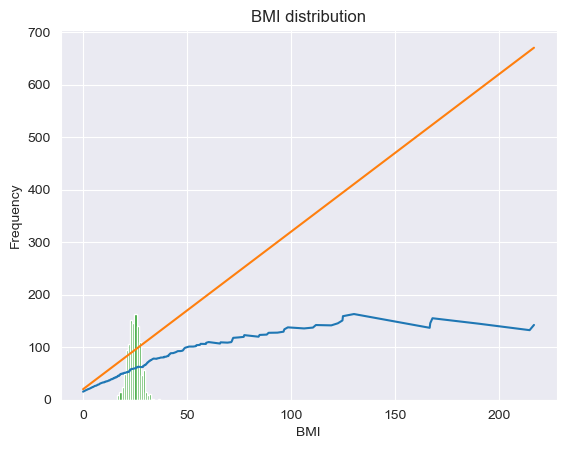

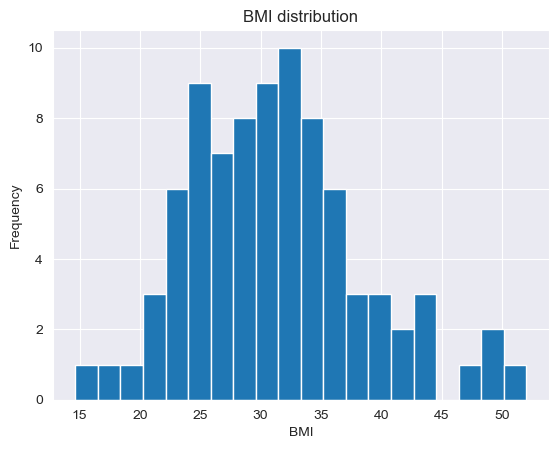

In [1]:
from statistics import correlation
from unittest.mock import inplace

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dask.bag.core import to_dataframe
from math import log
from math import e

from statsmodels.sandbox.distributions.genpareto import method
from tensorflow.python.feature_column.feature_column import linear_model

cox_data = pd.read_csv('/Users/gengzhi/Desktop/all_data.csv')
evaluated_data = pd.read_table('/Users/gengzhi/Desktop/nhanse_stroke.txt')
evaluated_data = evaluated_data.drop(90,axis=0)

cox_data =cox_data[cox_data['surgical_classify']!=1]
cox_data['BMI'].plot(kind='hist',bins=20)
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.title('BMI distribution')
plt.savefig('/Users/gengzhi/Desktop/BMI_distribution.pdf',backend='pgf')
plt.show()
evaluated_data['BMI'].plot(kind='hist',bins=20)
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.title('BMI distribution')
plt.savefig('/Users/gengzhi/Desktop/BMI_distribution_nhanse.pdf',backend='pgf')

In [2]:
evaluated_data = evaluated_data[evaluated_data['BMI']>26]
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
evaluated_data_array = imputer.fit_transform(evaluated_data)
evaluated_data = pd.DataFrame(evaluated_data_array,columns=evaluated_data.columns)

In [3]:
cox_data = cox_data[evaluated_data.columns]
def return_same(a,b):
    set1 = []
    for i in range(0,len(a)):
          if a.iloc[i] == b.iloc[i] == True:
             set1.append(1)
          else:
             set1.append(0)
    return to_dataframe(set1,columns=['judge'],dtypes='int64')
def get_index(a):
    index = []
    for i in range(0,len(a)):
        if a.iloc[i] == 1:
            index.append(i)
    return index

In [4]:
deleted = []
positive_percentage = []
positive_percentage_nhanse = []
for i in range(1,1870):
    data = cox_data.copy()
    index = range(0,1149)
    data.index = index
    data['test'] = data['survival_time'] < i
    data['judge']= return_same(data['survival_time'] < i,data['death'] == 0)
    data["SSUM"+str(i)] = data['judge'] + data['test']
    data=data.drop(['test','judge','survival_time','death'],axis=1)
    deleted.append(len(get_index(data['SSUM'+str(i)]==2)))
    data=data.drop(get_index(data['SSUM'+str(i)]==2),axis = 0)
    positive_percentage.append(sum(data['SSUM'+str(i)])/len(data['SSUM'+str(i)]))
for i in range(4,181):
    data = evaluated_data.copy()
    index = range(0,63)
    data.index = index
    data['test'] = data['survival_time'] < i
    data['judge']= return_same(data['survival_time'] < i,data['death'] == 0)
    data["SSUM"+str(i)] = data['judge'] + data['test']
    data=data.drop(['test','judge','survival_time','death'],axis=1)
    deleted.append(len(get_index(data['SSUM'+str(i)]==2)))
    data=data.drop(get_index(data['SSUM'+str(i)]==2),axis = 0)
    positive_percentage_nhanse.append(sum(data['SSUM'+str(i)])/len(data['SSUM'+str(i)]))

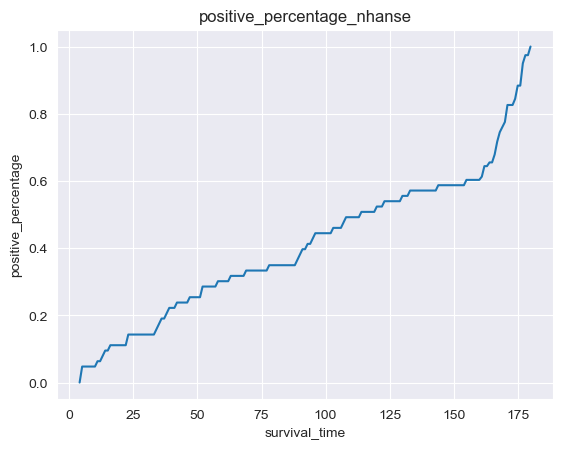

In [5]:
x = range(4,181)
plt.plot(x,positive_percentage_nhanse)
plt.xlabel('survival_time')
plt.ylabel('positive_percentage')
plt.title('positive_percentage_nhanse')
plt.savefig('/Users/gengzhi/Desktop/positive_percentage_nhanse.pdf',backend='pgf')

In [6]:
positive_percentage_ln = []
for i in range(1,1869):
    positive_percentage_ln.append(log(positive_percentage[i],e))
death_rate_ln = pd.DataFrame(positive_percentage_ln,columns=['death_rate_ln'],index=range(1,1869))
index = range(0,1149)
cox_data.index = index
for i in range(0,1149):
    cox_data.loc[i,'death_rate_ln'] = death_rate_ln.loc[cox_data.loc[i,'survival_time'],'death_rate_ln']
positive_percentage_nhanse_ln = []
for i in range(1,177):
    positive_percentage_nhanse_ln.append(log(positive_percentage_nhanse[i],e))
death_rate_nhanse_ln = pd.DataFrame(positive_percentage_nhanse_ln,columns=['death_rate_ln'],index=range(4,180))
index = range(0,63)
evaluated_data.index = index
for i in range(0,63):
    evaluated_data.loc[i,'death_rate_ln'] = death_rate_nhanse_ln.loc[evaluated_data.loc[i,'survival_time'],'death_rate_ln']

In [7]:
cox_data = cox_data[cox_data['death']==1]

In [8]:
from statsmodels.regression import linear_model as lm
cox_data = cox_data.drop(['death','survival_time'],axis=1)
male_cox_data = cox_data[cox_data['sex']==1]
female_cox_data = cox_data[cox_data['sex']==0]
X = cox_data.drop(['death_rate_ln'],axis=1)
X['intercept'] = 1

In [9]:
Y = cox_data['death_rate_ln']
model = lm.GLS(Y,X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            GLS Regression Results                            
==============================================================================
Dep. Variable:          death_rate_ln   R-squared:                       0.211
Model:                            GLS   Adj. R-squared:                 -0.011
Method:                 Least Squares   F-statistic:                    0.9516
Date:                Mon, 30 Dec 2024   Prob (F-statistic):              0.555
Time:                        10:33:24   Log-Likelihood:                -219.66
No. Observations:                 170   AIC:                             515.3
Df Residuals:                     132   BIC:                             634.5
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age            0.0028      0.009      0.295      0.768      -0.016       0.021
sex            0.0455      0.212      0.215      0.830      -0.374       0.465
BMI            0.0558      0.027      2.060      0.041       0.002       0.109
WBC           -0.0907      0.127     -0.713      0.477      -0.342       0.161
NEUT           0.1368      0.134      1.020      0.310      -0.129       0.402
LYMPH         -0.0556      0.221     -0.251      0.802      -0.493       0.382
MONO          -0.4855      0.436     -1.113      0.268      -1.348       0.377
EO             0.5501      1.016      0.542      0.589      -1.459       2.559
BASO           6.9588      5.466      1.273      0.205      -3.853      17.771
RBC           -0.1540      0.451     -0.342      0.733      -1.046       0.738
HGB            0.0107      0.014      0.765      0.446      -0.017       0.038
HCT            0.0023      0.008      0.293      0.770      -0.013       0.018
MCH            0.0327      0.072      0.453      0.651      -0.110       0.175
MCHC          -0.0009      0.009     -0.091      0.928      -0.020       0.018
RDW_CV         0.0694      0.070      0.993      0.322      -0.069       0.208
PLT           -0.0016      0.002     -0.857      0.393      -0.005       0.002
SII        -9.993e-05      0.000     -0.824      0.411      -0.000       0.000
MPV           -0.1274      0.092     -1.390      0.167      -0.309       0.054
TP             0.0152      0.023      0.657      0.512      -0.031       0.061
ALB            0.0005      0.002      0.281      0.780      -0.003       0.004
GLO           -0.0237      0.032     -0.735      0.464      -0.087       0.040
ALP            0.0034      0.003      1.152      0.251      -0.002       0.009
Na            -0.0019      0.029     -0.065      0.948      -0.060       0.056
CL             0.0107      0.032      0.338      0.736      -0.052       0.073
Ca            -0.1186      0.829     -0.143      0.886      -1.759       1.522
TC            -0.2208      0.109     -2.033      0.044      -0.436      -0.006
TG             0.1359      0.077      1.759      0.081      -0.017       0.289
GLU            0.0259      0.030      0.859      0.392      -0.034       0.086
ALT           -0.0023      0.007     -0.338      0.736      -0.016       0.011
AST           -0.0010      0.009     -0.114      0.909      -0.018       0.016
AST_ALT        0.0784      0.206      0.380      0.704      -0.329       0.486
GGT_Y          0.0028      0.004      0.653      0.515      -0.006       0.011
LDH           -0.0014      0.001     -1.203      0.231      -0.004       0.001
APOB          -0.4479      0.451     -0.992      0.323      -1.341       0.445
eGFR_CKD       0.0035      0.005      0.681      0.497      -0.007       0.014
HDL_C          0.3011      0.327      0.921      0.359      -0.345       0.948
LD

In [10]:
coef = model.params
evaluated_data = evaluated_data[evaluated_data['death']==1]
index = range(0,38)
evaluated_data.index = index
X = evaluated_data.drop(['death','survival_time','death_rate_ln'],axis=1)
X['intercept'] = 1
Y = evaluated_data['death_rate_ln']
computed_ln = np.dot(X,coef)
R_square = 1 - sum((Y-computed_ln)**2)/sum((Y-np.mean(Y))**2)
R_square

-1.071819543671447

In [11]:
Y_pred = np.exp(np.dot(X,coef))



In [12]:
from sklearn.metrics import roc_auc_score
Y = np.exp(Y)
set_Y = []
Y_dropmin = Y.drop([6,27,34])
for value in Y_dropmin:
    set_Y.append(roc_auc_score(Y<value,1-Y_pred))
    

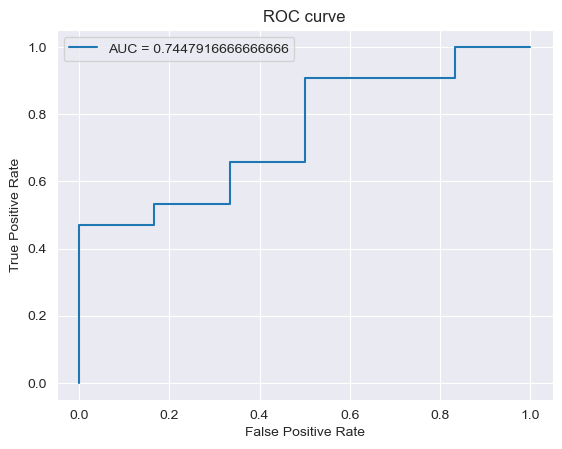

In [13]:
from sklearn.metrics import roc_curve
fpr,tpr,thresholds = roc_curve(Y<Y_dropmin[5],1-Y_pred)
best_threshold = thresholds[np.argmax(tpr-fpr)]
plt.plot(fpr,tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(['AUC = {}'.format(roc_auc_score(Y<Y_dropmin[5],1-Y_pred))])
plt.savefig('/Users/gengzhi/Desktop/ROC_curve.pdf',backend='pgf')

In [14]:
# calculated the correlation between the predicted death_rate and the true death_rate by kandall's tau
import scipy.stats as stats
stats.pearsonr(Y,Y_pred)

PearsonRResult(statistic=0.2767100349901592, pvalue=0.09260915651473395)

In [15]:
model.rsquared_adj-R_square

1.0611063778282666

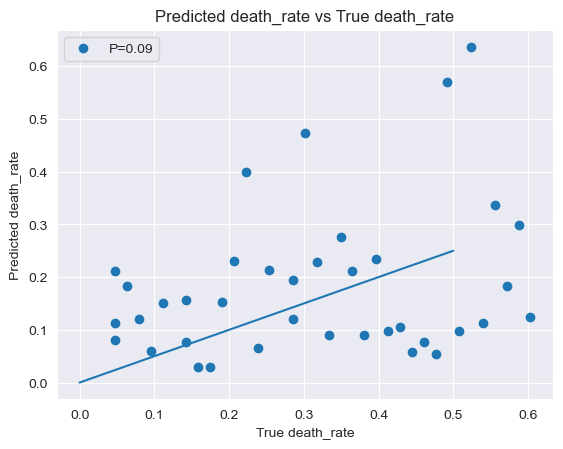

In [16]:
from numpy import linspace
plt.scatter(Y,Y_pred)
x = linspace(0,0.5,100)
y = 0.5*x
plt.plot(x,y)
plt.xlabel('True death_rate')
plt.ylabel('Predicted death_rate')
plt.title('Predicted death_rate vs True death_rate')
plt.legend(['P=0.09'])
plt.savefig('/Users/gengzhi/Desktop/Predicted_death_rate_vs_True_death_rate.pdf',backend='pgf')

In [17]:

lm.OLS(Y_pred,Y).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.603
Model:                            OLS   Adj. R-squared (uncentered):              0.593
Method:                 Least Squares   F-statistic:                              56.27
Date:                Mon, 30 Dec 2024   Prob (F-statistic):                    6.16e-09
Time:                        10:33:27   Log-Likelihood:                          19.448
No. Observations:                  38   AIC:                                     -36.90
Df Residuals:                      37   BIC:                                     -35.26
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
death_rate_ln     0.5028      0.067      7.501      0.000       0.367       0.639
==============================================================================
Omnibus:                        2.744   Durbin-Watson:                   1.899
Prob(Omnibus):                  0.254   Jarque-Bera (JB):                2.237
Skew:                           0.592   Prob(JB):                        0.327
Kurtosis:                       2.905   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""